# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados 2020

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares multivariados na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Treinamento das Redes Neurais - Série Univariada

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima, nsdiffs, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(10,7)})

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])

Removendo as últimas linhas que são todas NaN

In [5]:
df_main = df_main_orig.iloc[0:216]
datas = df_main['date']

In [6]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
211,2020-08-01,1.227731e+10,832.313,5.461233,135.61,21,832.313,5.461233,135.61,832.313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,2020-09-01,1.309835e+10,868.442,5.399486,137.09,21,868.442,5.399486,137.09,868.442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,2020-10-01,1.387787e+10,896.505,5.625790,139.80,21,896.505,5.625790,139.80,896.505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,2020-11-01,1.474590e+10,925.887,5.417835,138.14,20,925.887,5.417835,138.14,925.887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,2020-12-01,1.490640e+10,934.758,5.145586,139.27,22,934.758,5.145586,139.27,934.758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Criação das Séries

In [7]:
icms_ts = pd.Series(list(df_main['icms_sp']), index = datas)

#### Testes de Valores Nulos

In [8]:
print('ICMS', icms_ts.isnull().sum())

ICMS 0


In [9]:
# listando os nulos do icms
icms_ts[icms_ts.isnull()]

Series([], dtype: float64)

In [10]:
# eliminando os nulos do icms
icms_ts = icms_ts[~icms_ts.isnull()]

In [11]:
icms_ts.shape

(216,)

### Série em Log
Como os valores do ICMS são muito elevados a série será colocada em log.

In [12]:
l_icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)

## Divisão em treino e teste

In [13]:
icms_train = icms_ts[:-24]
icms_val = icms_ts[-24:-12]
icms_test = icms_ts[-12:]

In [18]:
print('#'*30+'\n',icms_train)
print('#'*30+'\n',icms_val)
print('#'*30+'\n',icms_test)

##############################
 date
2003-01-01    3.360296e+09
2003-02-01    3.196558e+09
2003-03-01    3.160011e+09
2003-04-01    3.215307e+09
2003-05-01    3.098930e+09
                  ...     
2018-08-01    1.157415e+10
2018-09-01    1.157068e+10
2018-10-01    1.176202e+10
2018-11-01    1.150136e+10
2018-12-01    1.196787e+10
Length: 192, dtype: float64
##############################
 date
2019-01-01    1.236685e+10
2019-02-01    1.126598e+10
2019-03-01    1.131000e+10
2019-04-01    1.201696e+10
2019-05-01    1.173362e+10
2019-06-01    1.138744e+10
2019-07-01    1.177099e+10
2019-08-01    1.178403e+10
2019-09-01    1.214739e+10
2019-10-01    1.251718e+10
2019-11-01    1.257453e+10
2019-12-01    1.314626e+10
dtype: float64
##############################
 date
2020-01-01    1.292981e+10
2020-02-01    1.177686e+10
2020-03-01    1.208593e+10
2020-04-01    1.045560e+10
2020-05-01    9.023529e+09
2020-06-01    9.983544e+09
2020-07-01    1.134873e+10
2020-08-01    1.227731e+10
2020-09-0

## Utilidades para Previsões

Além de MAPE e MSE, será usado o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [19]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões
Será usado para armazenar todas as previsões.

In [20]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série
As redes neurais precisam de conjuntos de características e de etiquetas separados. Neste caso, o conjunto de etiquetas é a própria série de ICMS. Para os conjunto de caraterísticas será utilizada a série do ICMS com lags 1, 2, 3, 4, 6 e 12 defasagens, e médias móveis de 2, 3, 6 e 12 meses, conforme trabalho de [Silva & Figueiredo, 2020].

In [21]:
def cria_features_target(serie, verbose=0):
    serie_d1 = serie.shift(1)
    serie_d2 = serie.shift(2)
    serie_d3 = serie.shift(3)
    serie_d4 = serie.shift(4)
    serie_d6 = serie.shift(6)
    serie_d12 = serie.shift(12)
    serie_ma2 = serie.rolling(2).mean()
    serie_ma3 = serie.rolling(3).mean()
    serie_ma6 = serie.rolling(6).mean()
    serie_ma12 = serie.rolling(12).mean()

    if verbose==1:
        print("shape de cada uma das séries:")
        print(serie_d1.shape, serie_d2.shape, serie_d3.shape, serie_d4.shape, 
              serie_d6.shape, serie_d12.shape, serie_ma2.shape, serie_ma3.shape, 
              serie_ma6.shape, serie_ma12.shape)
    X = np.array([serie_d1, serie_d2, serie_d3, serie_d4, 
     serie_d6, serie_d12, serie_ma2, serie_ma3, 
     serie_ma6, serie_ma12])
    if verbose==1:
        print("shape do array de features:", X.shape)
    X = X[:,12:]
    X = X.T
    if verbose==1:
        print("shape do array de features depois da poda e da transposição:", X.shape)
    Y = np.array(serie[12:])
    if verbose==1:
        print("shape do array target:", Y.shape)
    return X, Y

In [22]:
#série completa, com sazonalidade e em nível
#seas_icms_ts = seas_icms.seasadj
X_data, Y_data = cria_features_target(l_icms_ts, verbose=1)

shape de cada uma das séries:
(216,) (216,) (216,) (216,) (216,) (216,) (216,) (216,) (216,) (216,)
shape do array de features: (10, 216)
shape do array de features depois da poda e da transposição: (204, 10)
shape do array target: (204,)


In [23]:
#print(X_data[0])
#print(Y_data[0])
#print(X_data[X_data.shape[0]-1])
#print(Y_data[X_data.shape[0]-1])

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [24]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
#Y_train = Y_data[:-24]
#Y_val = Y_data[-24:-12]
#Y_test = Y_data[-12:]
#print(Y_train.shape, Y_val.shape, Y_test.shape)

(180, 10) (12, 10) (12, 10)


In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(10))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)

#enc_y = MinMaxScaler()

#print(enc_y)
#Y_train_std = enc_y.fit_transform(Y_train.reshape(Y_train.shape[0], 1))
#Y_val_std = enc_y.transform(Y_val.reshape(12,1))
#Y_test_std = enc_y.transform(Y_test.reshape(12,1))

#print(Y_train_std.shape)
#print(Y_val_std.shape)
#print(Y_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(180, 10)
(12, 10)
(12, 10)


# Modelo 1 mês
Neste modelo cada mês será previsto pelos dados do mês anterior

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

In [26]:
X_data_jn = np.concatenate((X_train_std, X_val_std, X_test_std), axis = 0)
X_data_jn = X_data_jn.reshape(X_data_jn.shape[0],10,1)
print(X_data_jn.shape)

(204, 10, 1)


In [27]:
def janelamento_1_mes(X, Y, verbose=0):
    X_exp = np.roll(X, 1, axis=0)
    X_exp_cut = X_exp[1:,:,:]#.transpose(0,2,1)
    Y_cut = Y[1:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [28]:
X_data_exp_cut1, Y_data_cut1 = janelamento_1_mes(X_data_jn, Y_data, verbose=0)

In [29]:
X_data_exp_cut1.shape, Y_data_cut1.shape

((203, 10, 1), (203,))

In [30]:
X_data_exp_cut1[0]

array([[0.15676854],
       [0.05127581],
       [0.03750632],
       [0.01846507],
       [0.00891757],
       [0.06195622],
       [0.09248639],
       [0.055686  ],
       [0.        ],
       [0.        ]])

In [31]:
Y_data_cut1[0]

21.905893928886627

In [32]:
Y_data_cut1[Y_data_cut1.shape[0]-1]

23.425056612309927

In [33]:
X_data_exp_cut1[Y_data_cut1.shape[0]-1]

array([[1.1290071 ],
       [1.08392306],
       [1.03644518],
       [0.97493142],
       [0.80062037],
       [1.07168997],
       [1.15874891],
       [1.13667195],
       [1.05608977],
       [1.04449814]])

#### Separando novamente em treino, validação e teste

In [34]:
x_train1 = X_data_exp_cut1[:-24]
x_val1 = X_data_exp_cut1[-24:-12]
x_test1 = X_data_exp_cut1[-12:]
print(x_train1.shape, x_val1.shape, x_test1.shape)
y_train1 = Y_data_cut1[:-24]
y_val1 = Y_data_cut1[-24:-12]
y_test1 = Y_data_cut1[-12:]
print(y_train1.shape, y_val1.shape, y_test1.shape)

(179, 10, 1) (12, 10, 1) (12, 10, 1)
(179,) (12,) (12,)


### Criando o modelo LSTM 

In [35]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

## Arquitetura da Rede - Arquitetura Larga

In [36]:
rlrop1 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stop1 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [37]:
# Épocas e tamanho do lote
EPOCHS = 1000
BATCH = 4
NEURONIOS = 1200
LR = 1e-5
DROPOUT = 0.2

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (10, 1), return_sequences = False,
        units = NEURONIOS))

# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=LR))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1200)              5769600   
_________________________________________________________________
dense (Dense)                (None, 1)                 1201      
Total params: 5,770,801
Trainable params: 5,770,801
Non-trainable params: 0
_________________________________________________________________


In [39]:
# History object for plotting our model loss by epoch
history1 = model.fit(x_train1, y_train1, batch_size = BATCH, 
                    epochs = EPOCHS, validation_data = (x_val1, y_val1),
                    callbacks = [rlrop1, early_stop1])

Epoch 1/1000
45/45 [==============================] - 6s 126ms/step - loss: 99.6932 - val_loss: 98.7136
Epoch 2/1000
45/45 [==============================] - 5s 116ms/step - loss: 98.4810 - val_loss: 96.0179
Epoch 3/1000
45/45 [==============================] - 5s 116ms/step - loss: 95.1647 - val_loss: 85.0309
Epoch 4/1000
45/45 [==============================] - 5s 118ms/step - loss: 70.8693 - val_loss: 1.8914
Epoch 5/1000
45/45 [==============================] - 5s 114ms/step - loss: 22.1611 - val_loss: 5.8495
Epoch 6/1000
45/45 [==============================] - 5s 121ms/step - loss: 8.3186 - val_loss: 0.1620
Epoch 7/1000
45/45 [==============================] - 6s 123ms/step - loss: 2.7348 - val_loss: 0.6376
Epoch 8/1000
45/45 [==============================] - 6s 123ms/step - loss: 1.6856 - val_loss: 0.6154
Epoch 9/1000
45/45 [==============================] - 5s 116ms/step - loss: 1.4135 - val_loss: 0.8834
Epoch 10/1000
45/45 [==============================] - 5s 119ms/step - los

Epoch 72/1000
45/45 [==============================] - 9s 205ms/step - loss: 0.9031 - val_loss: 0.9892
Epoch 73/1000
45/45 [==============================] - 9s 210ms/step - loss: 0.9388 - val_loss: 0.9892
Epoch 74/1000
45/45 [==============================] - 10s 222ms/step - loss: 0.8572 - val_loss: 0.9892
Epoch 75/1000
45/45 [==============================] - 10s 221ms/step - loss: 0.8547 - val_loss: 0.9892
Epoch 76/1000
45/45 [==============================] - ETA: 0s - loss: 0.8684
Epoch 00076: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
45/45 [==============================] - 10s 212ms/step - loss: 0.8684 - val_loss: 0.9892
Epoch 77/1000
45/45 [==============================] - 10s 220ms/step - loss: 0.9408 - val_loss: 0.9892
Epoch 78/1000
45/45 [==============================] - 10s 226ms/step - loss: 0.8981 - val_loss: 0.9892
Epoch 79/1000
45/45 [==============================] - 10s 215ms/step - loss: 0.8906 - val_loss: 0.9892
Epoch 80/1000
45/45 [=====

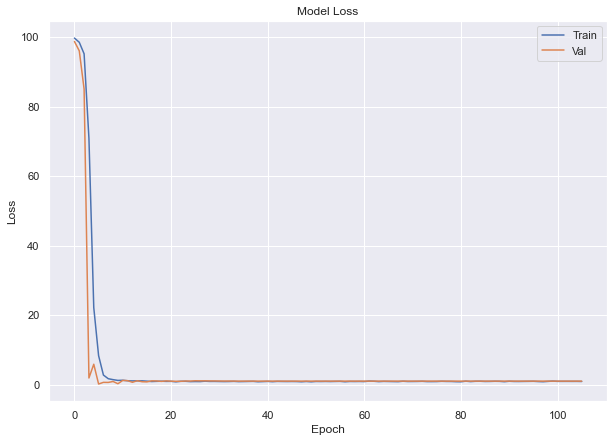

In [40]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses em Validação
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [41]:
# remove
serie_multi1 = l_icms_ts[:-24]
print(l_icms_ts.shape)
print(serie_multi1.shape)

(216,)
(192,)


In [42]:
for i in range(12):
    # cria as séries
    X_multi1, Y_multi1 = cria_features_target(serie_multi1, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std1 = enc_x.transform(X_multi1)
    X_multi_std1 = X_multi_std1.reshape(X_multi_std1.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi1, y_multi1 = janelamento_1_mes(X_multi_std1, Y_multi1, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi1 = model.predict(x_multi1[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi1))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi1 = pd.Series(np.append(serie_multi1, y_pred_multi1))

0 [[1.1825358e+10]]
1 [[1.179947e+10]]
2 [[1.1850035e+10]]
3 [[1.1863333e+10]]
4 [[1.1862678e+10]]
5 [[1.1866185e+10]]
6 [[1.1867203e+10]]
7 [[1.1872296e+10]]
8 [[1.1870463e+10]]
9 [[1.1870078e+10]]
10 [[1.1870938e+10]]
11 [[1.1870395e+10]]


In [43]:
Y_pred_multi1 = np.exp(pd.Series(serie_multi1[-12:]))
Y_pred_multi1.index = icms_val.index

In [44]:
Y_pred_multi1

date
2019-01-01    1.182536e+10
2019-02-01    1.179947e+10
2019-03-01    1.185004e+10
2019-04-01    1.186333e+10
2019-05-01    1.186268e+10
2019-06-01    1.186618e+10
2019-07-01    1.186720e+10
2019-08-01    1.187230e+10
2019-09-01    1.187046e+10
2019-10-01    1.187008e+10
2019-11-01    1.187094e+10
2019-12-01    1.187039e+10
dtype: float64

In [45]:
RMSE_lstm_multi1 = mean_squared_error(icms_val, Y_pred_multi1, squared=False)
RMSE_lstm_multi1

560821302.0490772

In [46]:
MAPE_lstm_multi1 = mean_absolute_percentage_error(icms_val, Y_pred_multi1)
MAPE_lstm_multi1

0.03732290668944217

In [47]:
previsoes['nome'].append('RNN-LSTM-1-mês-larga')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(Y_pred_multi1)

previsoes['rmse'].append(RMSE_lstm_multi1)

previsoes['mape'].append(MAPE_lstm_multi1)

previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi1
                                                        , icms_val)])

## Arquitetura da Rede - Arquitetura Multicamada

In [48]:
rlrop3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop3 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [49]:
# Épocas e tamanho do lote
EPOCHS3 = 1000
BATCH3 = 8
NEURONIOS3 = 600
LR3 = 1e-5
DROPOUT3 = 0.25

# Imstanciação do modelo
model3 = Sequential()

# Adicionar camada LSTM 
model3.add(LSTM(activation='tanh', dropout=DROPOUT3,
        input_shape = (10, 1), return_sequences = True,
        units = NEURONIOS3))

# Adicionar camada LSTM 
model3.add(LSTM(activation='tanh', dropout=DROPOUT3,
        input_shape = (10, 1), return_sequences = True,
        units = NEURONIOS3))

# Adicionar camada LSTM 
model3.add(LSTM(activation='tanh', dropout=DROPOUT3,
        input_shape = (10, 1), return_sequences = False,
        units = NEURONIOS3))


# Adicionar a camada de saída com 1 neurônio linear
model3.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model3.compile(loss = 'mape', optimizer = Adam(learning_rate=LR3))

In [50]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 600)           1444800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 600)           2882400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 7,210,201
Trainable params: 7,210,201
Non-trainable params: 0
_________________________________________________________________


In [51]:
# History object for plotting our model loss by epoch
history3 = model3.fit(x_train1, y_train1, batch_size = BATCH3, 
                    epochs = EPOCHS, validation_data = (x_val1, y_val1),
                    callbacks = [rlrop3, early_stop3])

Epoch 1/1000
23/23 [==============================] - 10s 449ms/step - loss: 99.8409 - val_loss: 99.4457
Epoch 2/1000
23/23 [==============================] - 7s 298ms/step - loss: 99.4145 - val_loss: 98.6404
Epoch 3/1000
23/23 [==============================] - 7s 306ms/step - loss: 98.6851 - val_loss: 97.0276
Epoch 4/1000
23/23 [==============================] - 7s 310ms/step - loss: 97.1298 - val_loss: 93.0692
Epoch 5/1000
23/23 [==============================] - 8s 337ms/step - loss: 92.5655 - val_loss: 80.5485
Epoch 6/1000
23/23 [==============================] - 5s 216ms/step - loss: 78.6083 - val_loss: 40.4147
Epoch 7/1000
23/23 [==============================] - 5s 205ms/step - loss: 41.8834 - val_loss: 5.5986
Epoch 8/1000
23/23 [==============================] - 4s 192ms/step - loss: 18.0899 - val_loss: 11.6947
Epoch 9/1000
23/23 [==============================] - 4s 189ms/step - loss: 12.3731 - val_loss: 5.9030
Epoch 10/1000
23/23 [==============================] - 5s 218ms/s

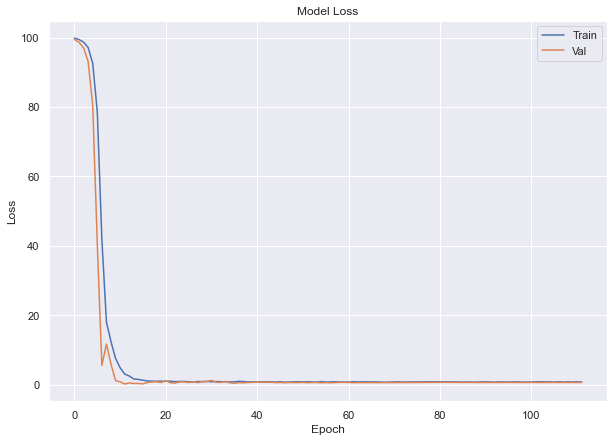

In [52]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses em Validação
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [53]:
# remove
serie_multi12 = l_icms_ts[:-24]
print(l_icms_ts.shape)
print(serie_multi1.shape)

(216,)
(204,)


In [54]:
for i in range(12):
    # cria as séries
    X_multi12, Y_multi12 = cria_features_target(serie_multi12, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std12 = enc_x.transform(X_multi12)
    X_multi_std12 = X_multi_std12.reshape(X_multi_std12.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi12, y_multi12 = janelamento_1_mes(X_multi_std12, Y_multi12, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi12 = model3.predict(x_multi12[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi12))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi12 = pd.Series(np.append(serie_multi12, y_pred_multi12))

0 [[1.2420435e+10]]
1 [[1.240881e+10]]
2 [[1.2475875e+10]]
3 [[1.2538186e+10]]
4 [[1.2583706e+10]]
5 [[1.2644792e+10]]
6 [[1.2658958e+10]]
7 [[1.2676161e+10]]
8 [[1.2708868e+10]]
9 [[1.2719659e+10]]
10 [[1.272791e+10]]
11 [[1.2738402e+10]]


In [55]:
Y_pred_multi12 = np.exp(pd.Series(serie_multi12[-12:]))
Y_pred_multi12.index = icms_val.index

In [56]:
Y_pred_multi12

date
2019-01-01    1.242044e+10
2019-02-01    1.240881e+10
2019-03-01    1.247588e+10
2019-04-01    1.253819e+10
2019-05-01    1.258371e+10
2019-06-01    1.264479e+10
2019-07-01    1.265896e+10
2019-08-01    1.267616e+10
2019-09-01    1.270887e+10
2019-10-01    1.271966e+10
2019-11-01    1.272791e+10
2019-12-01    1.273840e+10
dtype: float64

In [57]:
RMSE_lstm_multi12 = mean_squared_error(icms_val, Y_pred_multi12, squared=False)
RMSE_lstm_multi12

783898869.0308831

In [58]:
MAPE_lstm_multi12 = mean_absolute_percentage_error(icms_val, Y_pred_multi12)
MAPE_lstm_multi12

0.05765507700743861

In [59]:
previsoes['nome'].append('RNN-LSTM-1-mês-camadas')
previsoes['modelo'].append(model3)
previsoes['previsoes'].append(Y_pred_multi12)

previsoes['rmse'].append(RMSE_lstm_multi12)

previsoes['mape'].append(MAPE_lstm_multi12)

previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi12
                                                        , icms_val)])

# Modelo 12 meses

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

##### Unindo novamente os dados.

In [60]:
def janelamento_12_meses(X, Y, verbose=0):
    X_exp = np.concatenate((np.roll(X, 12, axis=0),
                            np.roll(X, 11, axis=0),
                            np.roll(X, 10, axis=0),
                            np.roll(X, 9, axis=0),
                            np.roll(X, 8, axis=0),
                            np.roll(X, 7, axis=0),
                            np.roll(X, 6, axis=0),
                            np.roll(X, 5, axis=0),
                            np.roll(X, 4, axis=0),
                            np.roll(X, 3, axis=0),
                            np.roll(X, 2, axis=0),
                            np.roll(X, 1, axis=0),
                            ), axis=2)
    X_exp_cut = X_exp[12:,:,:].transpose(0,2,1)
    Y_cut = Y[12:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [61]:
X_data_exp_cut12, Y_data_cut12 = janelamento_12_meses(X_data_jn, Y_data, verbose=0)

In [62]:
#Y_data_cut[0]

In [63]:
#X_data_exp_cut[0]

In [64]:
#Y_data_cut[Y_data_cut.shape[0]-1]

In [65]:
#X_data_exp_cut[Y_data_cut.shape[0]-1]

#### Separando novamente em treino, validação e teste

In [66]:
x_train12 = X_data_exp_cut12[:-24]
x_val12 = X_data_exp_cut12[-24:-12]
x_test12 = X_data_exp_cut12[-12:]
print(x_train12.shape, x_val12.shape, x_test12.shape)
y_train12 = Y_data_cut12[:-24]
y_val12 = Y_data_cut12[-24:-12]
y_test12 = np.exp(Y_data_cut12[-12:]) # tirar o log para ficar o valor real
print(y_train12.shape, y_val12.shape, y_test12.shape)

(168, 12, 10) (12, 12, 10) (12, 12, 10)
(168,) (12,) (12,)


### Criando o modelo LSTM

## Arquitetura da Rede - Arquitetura Larga

In [67]:
rlrop2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stop2 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [68]:
# Épocas e tamanho do lote
EPOCHS2 = 1000
BATCH2 = 8
NEURONIOS2 = 1000
LR2 = 1e-5
DROPOUT2 = 0.25

# Imstanciação do modelo
model2 = Sequential()

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = False,
        units = NEURONIOS2))

# Adicionar a camada de saída com 1 neurônio linear
model2.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model2.compile(loss = 'mape', optimizer = Adam(learning_rate=LR2))

In [69]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1000)              4044000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 4,045,001
Trainable params: 4,045,001
Non-trainable params: 0
_________________________________________________________________


In [70]:
# History object for plotting our model loss by epoch
history2 = model2.fit(x_train12, y_train12, batch_size = BATCH2, 
                    epochs = EPOCHS2, validation_data = (x_val12, y_val12),
                    callbacks = [rlrop2, early_stop2])

Epoch 1/1000
21/21 [==============================] - 2s 108ms/step - loss: 99.3332 - val_loss: 97.9177
Epoch 2/1000
21/21 [==============================] - 2s 96ms/step - loss: 98.0277 - val_loss: 95.5889
Epoch 3/1000
21/21 [==============================] - 2s 110ms/step - loss: 96.2902 - val_loss: 92.3750
Epoch 4/1000
21/21 [==============================] - 2s 113ms/step - loss: 93.7105 - val_loss: 86.6051
Epoch 5/1000
21/21 [==============================] - 3s 119ms/step - loss: 88.6369 - val_loss: 73.6603
Epoch 6/1000
21/21 [==============================] - 2s 115ms/step - loss: 75.8010 - val_loss: 41.9038
Epoch 7/1000
21/21 [==============================] - 2s 115ms/step - loss: 47.5916 - val_loss: 5.2912
Epoch 8/1000
21/21 [==============================] - 2s 114ms/step - loss: 21.5879 - val_loss: 5.7205
Epoch 9/1000
21/21 [==============================] - 2s 102ms/step - loss: 13.8560 - val_loss: 0.8245
Epoch 10/1000
21/21 [==============================] - 2s 104ms/step

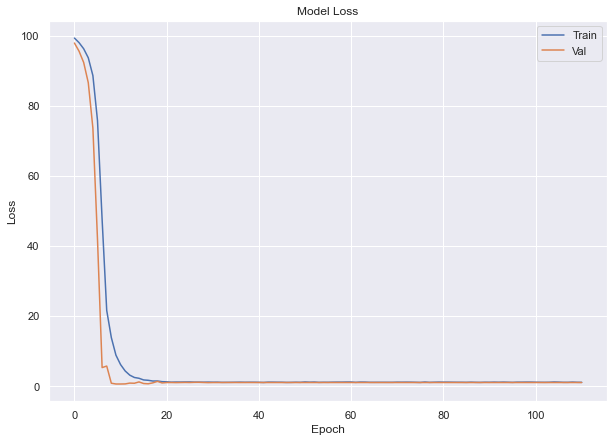

In [71]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses em Validação
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [72]:
# remove
serie_multi12 = l_icms_ts[:-24]
print(l_icms_ts.shape)
print(serie_multi12.shape)
type(serie_multi12)

(216,)
(192,)


pandas.core.series.Series

In [73]:
for i in range(12):
    # cria as séries
    X_multi12, Y_multi12 = cria_features_target(serie_multi12, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std12 = enc_x.transform(X_multi12)
    X_multi_std12 = X_multi_std12.reshape(X_multi_std12.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi12, y_multi12 = janelamento_12_meses(X_multi_std12, Y_multi12, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi12 = model2.predict(x_multi12[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi12))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi12 = pd.Series(np.append(serie_multi12, y_pred_multi12))
    type(serie_multi12)

0 [[1.043013e+10]]
1 [[1.0425775e+10]]
2 [[1.0417824e+10]]
3 [[1.0408289e+10]]
4 [[1.040958e+10]]
5 [[1.0423428e+10]]
6 [[1.0435084e+10]]
7 [[1.0452076e+10]]
8 [[1.047191e+10]]
9 [[1.0491103e+10]]
10 [[1.0505761e+10]]
11 [[1.0511093e+10]]


In [74]:
Y_pred_multi12 = np.exp(pd.Series(serie_multi12[-12:])) # tira o log das previsões
Y_pred_multi12.index = icms_val.index

In [75]:
Y_pred_multi12

date
2019-01-01    1.043013e+10
2019-02-01    1.042577e+10
2019-03-01    1.041782e+10
2019-04-01    1.040829e+10
2019-05-01    1.040958e+10
2019-06-01    1.042343e+10
2019-07-01    1.043508e+10
2019-08-01    1.045208e+10
2019-09-01    1.047191e+10
2019-10-01    1.049110e+10
2019-11-01    1.050576e+10
2019-12-01    1.051109e+10
dtype: float64

In [76]:
RMSE_lstm_multi12 = mean_squared_error(icms_val, Y_pred_multi12, squared=False)
RMSE_lstm_multi12

1638542637.253974

In [77]:
MAPE_lstm_multi12 = mean_absolute_percentage_error(icms_val, Y_pred_multi12)
MAPE_lstm_multi12

0.1277264455225185

In [78]:
previsoes['nome'].append('RNN-LSTM-12-meses-larga')
previsoes['modelo'].append(model2)
previsoes['previsoes'].append(Y_pred_multi12)

previsoes['rmse'].append(RMSE_lstm_multi12)

previsoes['mape'].append(MAPE_lstm_multi12)

In [79]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi12
                                                        , icms_val)])

## Arquitetura da Rede - Arquitetura Multicamada

In [80]:
rlrop4 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop4 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

In [81]:
# Épocas e tamanho do lote
EPOCHS4 = 1000
BATCH4 = 8
NEURONIOS4 = 600
LR4 = 1e-5
DROPOUT4 = 0.25

# Imstanciação do modelo
model4 = Sequential()

# Adicionar camada LSTM 
model4.add(LSTM(activation='tanh', dropout=DROPOUT4,
        input_shape = (12, 10), return_sequences = True,
        units = NEURONIOS4))

# Adicionar camada LSTM 
model4.add(LSTM(activation='tanh', dropout=DROPOUT4,
        input_shape = (12, 10), return_sequences = True,
        units = NEURONIOS4))

## Adicionar camada LSTM 
model4.add(LSTM(activation='tanh', dropout=DROPOUT4,
        input_shape = (12, 10), return_sequences = False,
        units = NEURONIOS4))


# Adicionar a camada de saída com 1 neurônio linear
model4.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model4.compile(loss = 'mape', optimizer = Adam(learning_rate=LR4))

In [82]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 12, 600)           1466400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 12, 600)           2882400   
_________________________________________________________________
lstm_7 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 601       
Total params: 7,231,801
Trainable params: 7,231,801
Non-trainable params: 0
_________________________________________________________________


In [83]:
# History object for plotting our model loss by epoch
history4 = model4.fit(x_train12, y_train12, batch_size = BATCH4, 
                    epochs = EPOCHS4, validation_data = (x_val12, y_val12),
                    callbacks = [rlrop4, early_stop4])

Epoch 1/1000
21/21 [==============================] - 3s 155ms/step - loss: 99.3902 - val_loss: 98.0357
Epoch 2/1000
21/21 [==============================] - 3s 128ms/step - loss: 98.0034 - val_loss: 95.1760
Epoch 3/1000
21/21 [==============================] - 3s 124ms/step - loss: 95.3972 - val_loss: 88.9926
Epoch 4/1000
21/21 [==============================] - 3s 125ms/step - loss: 89.0221 - val_loss: 71.7115
Epoch 5/1000
21/21 [==============================] - 3s 126ms/step - loss: 71.2369 - val_loss: 35.2243
Epoch 6/1000
21/21 [==============================] - 3s 126ms/step - loss: 39.8443 - val_loss: 7.2592
Epoch 7/1000
21/21 [==============================] - 3s 136ms/step - loss: 14.8613 - val_loss: 3.2741
Epoch 8/1000
21/21 [==============================] - 3s 122ms/step - loss: 7.8314 - val_loss: 0.3897
Epoch 9/1000
21/21 [==============================] - 4s 179ms/step - loss: 5.2938 - val_loss: 0.1579
Epoch 10/1000
21/21 [==============================] - 3s 125ms/step -

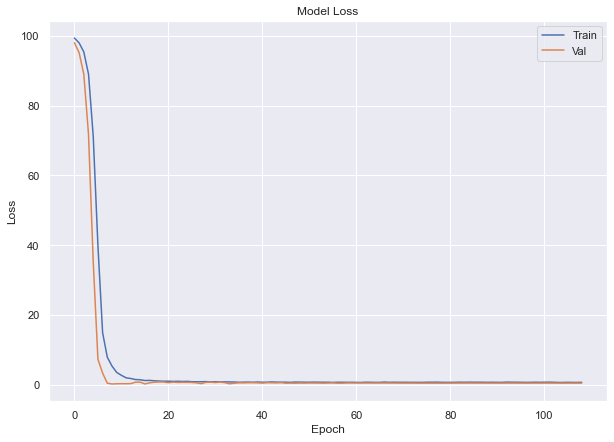

In [84]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses em Validação
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [85]:
# remove
serie_multi122 = l_icms_ts[:-24]
print(l_icms_ts.shape)
print(serie_multi122.shape)
type(serie_multi122)

(216,)
(192,)


pandas.core.series.Series

In [86]:
for i in range(12):
    # cria as séries
    X_multi122, Y_multi122 = cria_features_target(serie_multi122, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std122 = enc_x.transform(X_multi122)
    X_multi_std122 = X_multi_std122.reshape(X_multi_std122.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi122, y_multi122 = janelamento_12_meses(X_multi_std122, Y_multi122, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi122 = model4.predict(x_multi122[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi122))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi122 = pd.Series(np.append(serie_multi122, y_pred_multi122))
    type(serie_multi122)

0 [[1.2023223e+10]]
1 [[1.2029027e+10]]
2 [[1.202905e+10]]
3 [[1.203263e+10]]
4 [[1.2045443e+10]]
5 [[1.2058914e+10]]
6 [[1.2073804e+10]]
7 [[1.2093256e+10]]
8 [[1.2115257e+10]]
9 [[1.2137554e+10]]
10 [[1.2159033e+10]]
11 [[1.217335e+10]]


In [87]:
Y_pred_multi122 = np.exp(pd.Series(serie_multi122[-12:])) # tira o log das previsões
Y_pred_multi122.index = icms_val.index

In [88]:
Y_pred_multi122

date
2019-01-01    1.202322e+10
2019-02-01    1.202903e+10
2019-03-01    1.202905e+10
2019-04-01    1.203263e+10
2019-05-01    1.204544e+10
2019-06-01    1.205891e+10
2019-07-01    1.207380e+10
2019-08-01    1.209326e+10
2019-09-01    1.211526e+10
2019-10-01    1.213755e+10
2019-11-01    1.215903e+10
2019-12-01    1.217335e+10
dtype: float64

In [89]:
RMSE_lstm_multi122 = mean_squared_error(icms_val, Y_pred_multi122, squared=False)
RMSE_lstm_multi122

517795281.4253468

In [90]:
MAPE_lstm_multi122 = mean_absolute_percentage_error(icms_val, Y_pred_multi122)
MAPE_lstm_multi122

0.036493802091693624

In [91]:
previsoes['nome'].append('RNN-LSTM-12-meses-camadas')
previsoes['modelo'].append(model4)
previsoes['previsoes'].append(Y_pred_multi122)

previsoes['rmse'].append(RMSE_lstm_multi122)

previsoes['mape'].append(MAPE_lstm_multi122)

In [92]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi122
                                                        , icms_val)])

## Resultados

In [93]:
previsoes['nome']

['RNN-LSTM-1-mês-larga',
 'RNN-LSTM-1-mês-camadas',
 'RNN-LSTM-12-meses-larga',
 'RNN-LSTM-12-meses-camadas']

In [94]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_val
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [95]:
df_prev

,RNN-LSTM-1-mês-larga,RNN-LSTM-1-mês-camadas,RNN-LSTM-12-meses-larga,RNN-LSTM-12-meses-camadas,real
date,,,,,
2019-01-01,1.182536e+10,1.242044e+10,1.043013e+10,1.202322e+10,1.236685e+10
2019-02-01,1.179947e+10,1.240881e+10,1.042577e+10,1.202903e+10,1.126598e+10
2019-03-01,1.185004e+10,1.247588e+10,1.041782e+10,1.202905e+10,1.131000e+10
2019-04-01,1.186333e+10,1.253819e+10,1.040829e+10,1.203263e+10,1.201696e+10
2019-05-01,1.186268e+10,1.258371e+10,1.040958e+10,1.204544e+10,1.173362e+10
2019-06-01,1.186618e+10,1.264479e+10,1.042343e+10,1.205891e+10,1.138744e+10
2019-07-01,1.186720e+10,1.265896e+10,1.043508e+10,1.207380e+10,1.177099e+10
2019-08-01,1.187230e+10,1.267616e+10,1.045208e+10,1.209326e+10,1.178403e+10
2019-09-01,1.187046e+10,1.270887e+10,1.047191e+10,1.211526e+10,1.214739e+10


In [96]:
df_erro

,RNN-LSTM-1-mês-larga,RNN-LSTM-1-mês-camadas,RNN-LSTM-12-meses-larga,RNN-LSTM-12-meses-camadas
0,4.378576,0.433313,15.660571,2.778603
1,4.735411,10.144084,7.457898,6.773024
2,4.774865,10.308379,7.888379,6.357661
3,1.278404,4.337433,13.386656,0.130409
4,1.099868,7.244852,11.284176,2.657492
5,4.204114,11.041551,8.465602,5.896582
6,0.817360,7.543692,11.349145,2.572531
7,0.749024,7.570671,11.303055,2.624096
8,2.279689,4.622253,13.792882,0.264481
9,5.169686,1.617642,16.186346,3.032809


#### Previsões

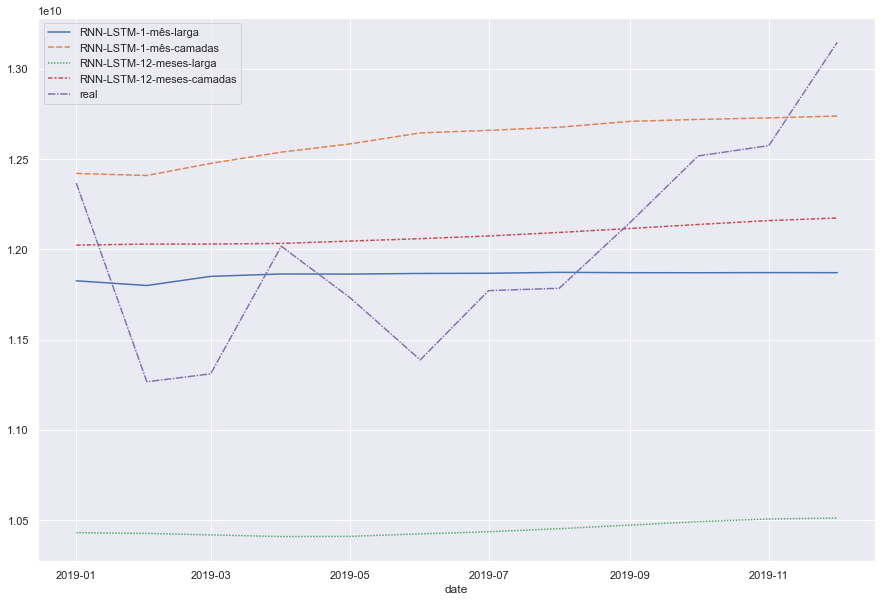

In [97]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev)

#### RMSE

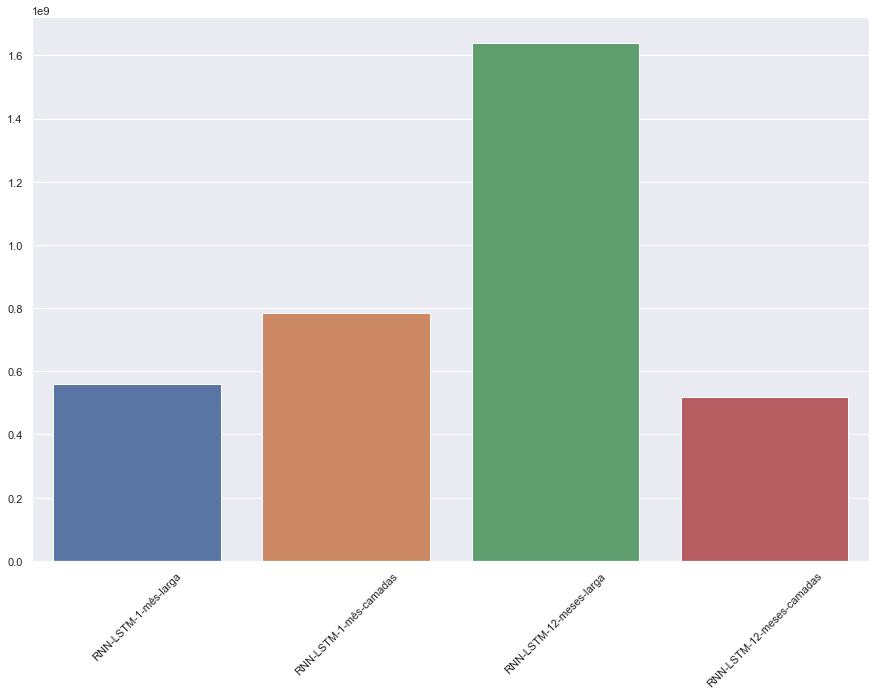

In [98]:
fig = plt.figure(figsize=(15, 10))
#df_rmse = df_rmse.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_rmse)
_ = plt.xticks(rotation=45)

#### MAPE

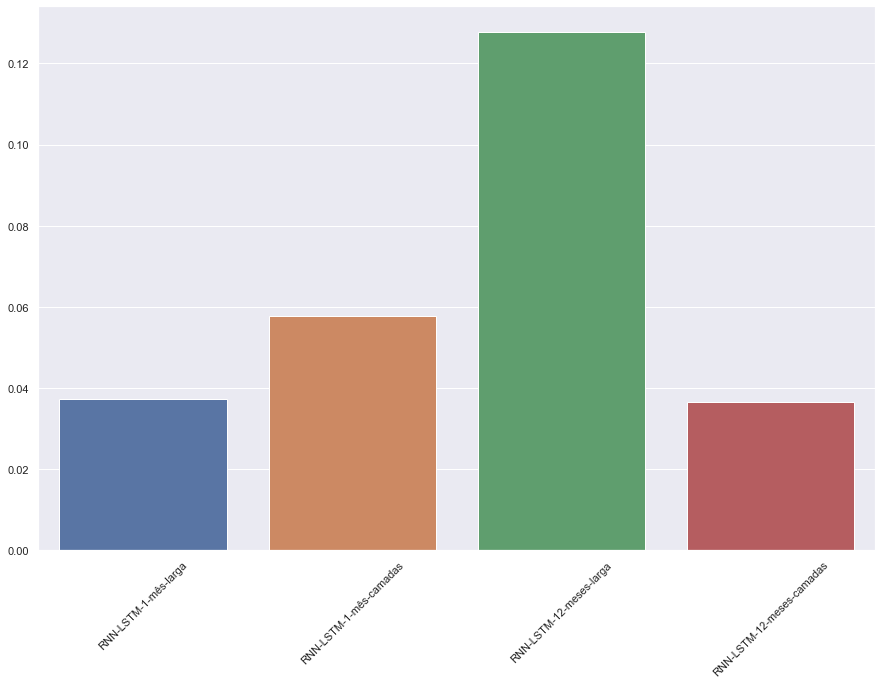

In [99]:
fig = plt.figure(figsize=(15, 10))
#df_mape = df_mape.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_mape)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [100]:
df_rmse.index = ['RMSE']
df_mape.index = ['MAPE']

In [101]:
df_metricas = df_rmse.copy()
df_metricas = df_metricas.append(df_mape.copy())
df_metricas

,RNN-LSTM-1-mês-larga,RNN-LSTM-1-mês-camadas,RNN-LSTM-12-meses-larga,RNN-LSTM-12-meses-camadas
RMSE,5.608213e+08,7.838989e+08,1.638543e+09,5.177953e+08
MAPE,3.732291e-02,5.765508e-02,1.277264e-01,3.649380e-02
